#           Поиск возможных партнеров среди АЗС для Яндекс.Навигатора


###### В файле visits.csv хранятся данные из Яндекс.Навигатор 

* Зашифрованное наименование сети АЗС (столбец name): вместо брендов — названия растений;
* Уникальный идентификатор конкретной АЗС (столбец id) — в сети их много;
* Время заезда на АЗС (столбец date_time) в формате ISO: 20190405T165358 означает, что водитель прибыл на заправку 5 апреля 2019 года в 16 часов 53 минуты 58 секунд по UTC.
* Проведённое на АЗС время (столбец time_spent) в секундах.
#### Нужно ответить на вопрос, сколько в среднем времени тратят водители на заправку в каждой из сетей АЗС.


In [1]:
import pandas as pd
path = 'C:/Users/Дарья/visits.csv'
data = pd.read_csv(path,sep = '\t')
data.head()

,date_time,id,time_spent,name
0,20180406T165358,76144fb2,98.0,Василек
1,20180404T173913,76144fb2,15.0,Василек
2,20180403T172824,76144fb2,220.0,Василек
3,20180407T070441,76144fb2,19.0,Василек
4,20180404T132049,76144fb2,14.0,Василек


###### Среднее время заправки для каждой сети

In [2]:
name_stat  = pd.pivot_table(data,index ='name', values='time_spent')
print(name_stat)

             time_spent
name                   
Агератум     337.802721
Амарант      132.760012
Аммобиум     256.708042
Арктотис      73.879984
Астильба     376.143149
Бальзамин    134.508411
Бархатцы     145.300328
Бегония      163.200647
Белоцветник  100.818966
Василек      268.849897
Вербена      190.016594
Вероника     220.019402
Гацания      160.685185
Гвоздика     294.317308
Гейхера      167.445947
Гелихризум   290.138643
Георгина     166.615555
Годеция      113.958333
Диморфотека  406.161017
Доротеантус  263.568916
Ирис         179.931159
Календула    207.357323
Колокольчик  119.131564
Космос       164.867797
Крокус       349.031746
Лаватера     249.992844
Левкой       187.465606
Лобулярия     96.834350
Люпин        235.440937
Малопа        76.070543
Мальва       136.562234
Нарцисс       68.166758
Настурция    154.859694
Незабудка    120.362398
Немезия      186.535207
Обриета      141.777778
Петуния      265.780822
Пион         222.565523
Подснежник   180.286207
Роза         260

Сети АЗС «Нарцисс», «Арктотис» и «Малопа» имеют среднее время заправки около 70 секунд. Неправдоподобно мало. Необходимо проверить данные.

In [3]:
total_visits = data.shape[0] 
print('Количество заездов:',total_visits)
total_stations = data.id.unique()
print('Количество АЗС:',len(total_stations))
print(data['date_time'].min(),data['date_time'].max())
total_days = 7
station_visits_per_day = total_visits/len(total_stations)/total_days
print('Количество заездов на АЗС в сутки:',station_visits_per_day)
print()
print("Топ-10 сетей с наибольшим количеством заездов")
data.name.value_counts().sort_values(ascending=False).head(10)

Количество заездов: 317104
Количество АЗС: 471
20180402T000008 20180408T235957
Количество заездов на АЗС в сутки: 96.17955717318775

Топ-10 сетей с наибольшим количеством заездов


Календула      85648
Василек        79006
Георгина       34356
Немезия        20138
Колокольчик    18835
Мальва         17386
Гейхера        14125
Доротеантус     6312
Нарцисс         3640
Амарант         3221
Name: name, dtype: int64

Гистограмма значений времени, проведённого на АЗС, с увеличенным до 100 числом столбцов.

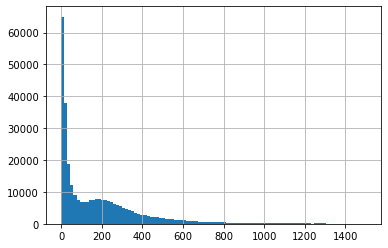

In [4]:
data.time_spent.hist(bins = 100,range=(0,1500))

Мощный пик на 0, и есть выбросы на 1200+ секунд, нужно проверить, правильно ли выгружаются данные и найти проблемы
Нарисуем диаграмму размаха для data

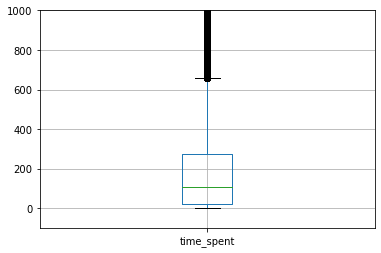

In [5]:
import matplotlib.pyplot as plt

plt.ylim(-100, 1000)
data.boxplot()

Характерные значения таблицы data.

In [6]:
data.describe()

,time_spent
count,317104.000000
mean,203.382294
std,395.754791
min,0.000000
25%,19.000000
50%,108.000000
75%,274.000000
max,28925.000000


Нетипично долгие заезды признаем выбросами и отбросим.
Во-первых, их немного. Во-вторых, скорее всего, такие заезды — не заправки. Например, водитель мог отдыхать, есть или заниматься чем-то ещё. Раз это не заправки в чистом виде, значит в рамках нашего исследования такие заезды не интересны.
Заправки продолжительностью 600 секунд — уже редки. Дольше 800 секунд почти не заправляются. А на участке более 1300 секунд гистограмма сливается с нулём (это не значит, что там ровно 0, но таких заправок единицы).
Примем верхнюю границу в 1000 секунд. Это число кажется разумным: дольше заправляются редко. Отбросив значения больше 1000, мы не потеряем много данных. Да и вряд ли водители тратят на заправку больше 1000 секунд (16 минут).

#### Переведем данные с датой и временем в понятный вид и к московскому времени, окурглим до часа


In [7]:
data['date_time'] = pd.to_datetime(data['date_time'], format = '%Y-%m-%dT%H:%M:%S')

data['local_time'] = data['date_time'] + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
data.head()

,date_time,id,time_spent,name,local_time,date_hour
0,2018-04-06 16:53:58,76144fb2,98.0,Василек,2018-04-06 19:53:58,2018-04-06 20:00:00
1,2018-04-04 17:39:13,76144fb2,15.0,Василек,2018-04-04 20:39:13,2018-04-04 21:00:00
2,2018-04-03 17:28:24,76144fb2,220.0,Василек,2018-04-03 20:28:24,2018-04-03 20:00:00
3,2018-04-07 07:04:41,76144fb2,19.0,Василек,2018-04-07 10:04:41,2018-04-07 10:00:00
4,2018-04-04 13:20:49,76144fb2,14.0,Василек,2018-04-04 16:20:49,2018-04-04 16:00:00


Проверим данные по отдельно взятой АЗС. Построим график зависимости продолжительности заправки от времени заезда.

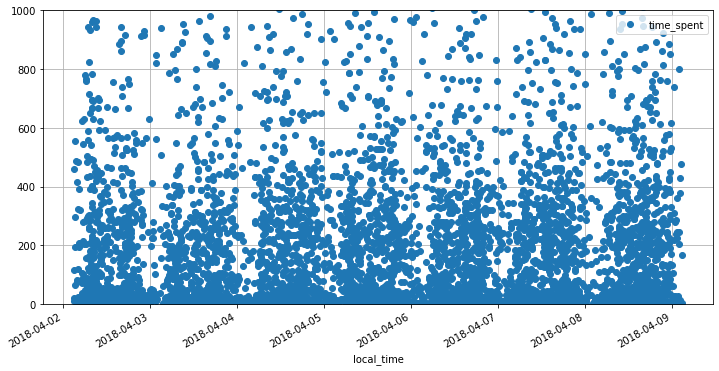

In [8]:
sample = data[data['id']=="3c1e4c52"]
sample.plot(y='time_spent', x='local_time',style='o', figsize = (12,6),ylim=(0, 1000),grid=True)

По графику видно, что ночью заездов меньше, но все еще не наглядно

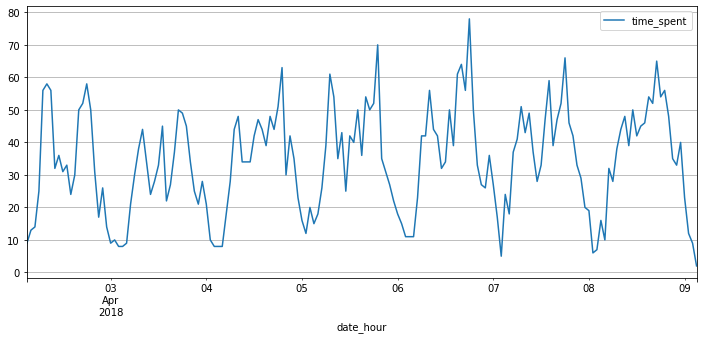

In [9]:
data.query('id == "3c1e4c52"')\
        .pivot_table(index='date_hour', values='time_spent', aggfunc='count')\
        .plot(grid=True, figsize=(12,5))

Вот теперь лучше видно, что заездов ночью в несколько раз меньше, чем днем.

Создадим столбец data['too_fast'] , со значениями:
* True — если время заезда менее 60 секунд
* False — если от 60 секунд


In [10]:
data['too_fast'] = data['time_spent'] < 60
data.head()

,date_time,id,time_spent,name,local_time,date_hour,too_fast
0,2018-04-06 16:53:58,76144fb2,98.0,Василек,2018-04-06 19:53:58,2018-04-06 20:00:00,False
1,2018-04-04 17:39:13,76144fb2,15.0,Василек,2018-04-04 20:39:13,2018-04-04 21:00:00,True
2,2018-04-03 17:28:24,76144fb2,220.0,Василек,2018-04-03 20:28:24,2018-04-03 20:00:00,False
3,2018-04-07 07:04:41,76144fb2,19.0,Василек,2018-04-07 10:04:41,2018-04-07 10:00:00,True
4,2018-04-04 13:20:49,76144fb2,14.0,Василек,2018-04-04 16:20:49,2018-04-04 16:00:00,True


In [11]:
data.too_fast.mean()

0.42213910893586964

Найдем долю аномально быстрых заправок для разных АЗС 

In [12]:
too_fast_stat = data.pivot_table(index='id', values = 'too_fast')
too_fast_stat.head()

,too_fast
id,
00ca1b70,0.250000
011f7462,0.637489
015eaddd,0.726190
0178ce70,0.211538
018a83ef,0.510269


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B09AC9D90>]],
      dtype=object)

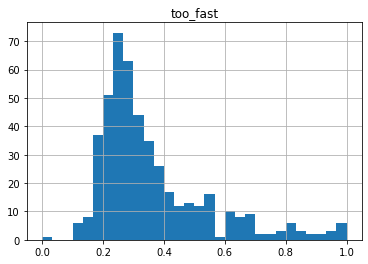

In [13]:
too_fast_stat.hist(bins =30)

Пик графика около 0.3, значит у большинства АЗС 30% заездов - аномально быстрые заезды. Но есть АЗС, где 100% заездов аномально быстрые.

Создадим столбец data['too_slow'] , со значениями:
* True — если время заезда более 1000 секунд
* False —  если время заезда менее или равно 1000 секундам

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B096A7790>]],
      dtype=object)

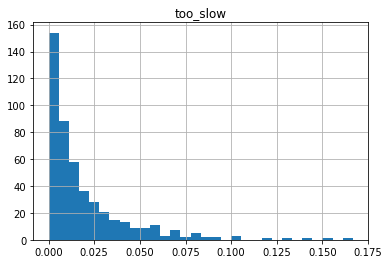

In [14]:
data['too_slow']=data['time_spent']>1000
data.pivot_table(index='id', values='too_slow').hist(bins =30)

Длинных заездов  гораздо меньше, чем коротких. У большинства их количество меньше 5%

##### Выберем из таблицы data данные только по АЗС с долей «аномально быстрых» заездов меньше 50%. Сравним число «хороших» АЗС с количеством всех АЗС.

In [15]:
good_ids = too_fast_stat.query('too_fast < 0.5')
print("Все заезды",len(data))
good_data = data.query('id in @good_ids.index') 
print("Хорошие заезды",len(good_data))

Все заезды 317104
Хорошие заезды 229095


Нормальная заправка должна длиться не меньше 60, но не больше 1000 секунд. Оставим в good_data только данные с нормальной продолжительностью заправки.

In [16]:
good_data = good_data.query('time_spent >= 60 and time_spent <= 1000')
print(good_data.shape[0])

154601


Уточним, какой стала типичная продолжительность заправки на АЗС, после очистки данных от аномальных заездов.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B09A943A0>]],
      dtype=object)

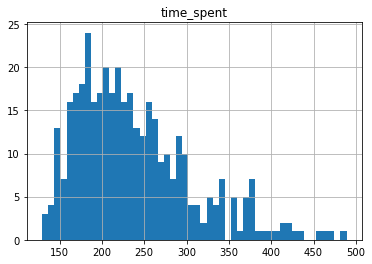

In [17]:
good_stations_stat = good_data.pivot_table(index ='id',values = 'time_spent', aggfunc = 'median')
good_stations_stat.hist(bins = 50)

Большая часть сдвинулась в диапазон 150-300, выглядит правдоподобно.

Всё готово для составления рейтинга сетей АЗС.
Построим рейтинг, где каждому названию сети АЗС соответствует медианное время заправки. 

In [18]:
good_stat = good_data.pivot_table(index ='name',values = 'time_spent', aggfunc = 'median')
good_stat.sort_values(by='time_spent')

,time_spent
name,
Белоцветник,154.0
Бальзамин,158.0
Незабудка,161.0
Колокольчик,161.0
Обриета,167.0
Функия,171.5
Гацания,178.5
Аммобиум,180.5
Пион,180.5


Добавим в stat столбец good_time_spent со значениями времени заправки в сети АЗС из good_stat

In [19]:
stat = data.pivot_table(index='name', values='time_spent')
stat['good_time_spent'] = good_stat['time_spent']
stat

,time_spent,good_time_spent
name,,
Агератум,337.802721,309.0
Амарант,132.760012,187.5
Аммобиум,256.708042,180.5
Арктотис,73.879984,185.0
Астильба,376.143149,423.0
Бальзамин,134.508411,158.0
Бархатцы,145.300328,181.5
Бегония,163.200647,195.0
Белоцветник,100.818966,154.0


Составим таблицу соответствия: идентификатор АЗС, название сети, число заездов.

In [20]:
id_name = good_data.pivot_table(index = 'id', values='name',aggfunc=['first', 'count'])
id_name.columns = ['name','count']
id_name.head()

,name,count
id,,
00ca1b70,Вероника,131
0178ce70,Василек,164
01abf4e9,Гацания,30
030a9067,Колокольчик,228
03740f2d,Василек,157


Объединим данные из id_name и good_stations_stat так, чтобы в итоговом датафрейме были все 3 столбца: 'name', 'count', 'time_spent'. Результат сохраним в таблице station_stat_full.

In [21]:
station_stat_full = id_name.merge(good_stations_stat, on='id',  how='inner')
station_stat_full.head()

,name,count,time_spent
id,,,
00ca1b70,Вероника,131,166.0
0178ce70,Василек,164,234.5
01abf4e9,Гацания,30,181.5
030a9067,Колокольчик,228,135.5
03740f2d,Василек,157,289.0


Нужно установить минимальную границу по числу заездов, ниже которой данные о среднем времени заправки можно считать ненадёжными (чтобы исключить их влияние на типичную продолжительность).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B0AA3E2E0>]],
      dtype=object)

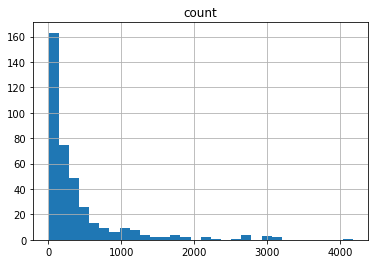

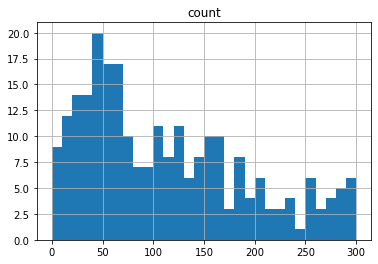

In [22]:
station_stat_full.hist('count',bins = 30)
station_stat_full.hist('count',bins = 30,range = (0,300))

На первой гистограмме пик около 0, на второй около 50, можнно отступить немного за пик и убрать все подозрительно непопулярные станции, на которые заезжали менее 75 раз, но и слишком много. Поэтому чтобы не проводить еще одно исследование, установим порог в 30 заездов.

АЗС с количеством заездов более 30. По этим данным найдем для каждой сети медиану продолжительности заправки и число АЗС.

In [23]:
good_stat2 = station_stat_full.query('count>30')\
                    .pivot_table(index = 'name', values = 'time_spent', aggfunc = ['median','count'])
good_stat2.columns= ['median_time','stations']      
good_stat2.head()

,median_time,stations
name,,
Агератум,308.50,3
Амарант,169.00,5
Аммобиум,178.75,4
Арктотис,190.50,3
Астильба,435.50,4


Объединим данные таблиц stat и good_stat2, чтобы получился датафрейм со столбцами: 'time_spent', 'good_time_spent', 'median_time', 'stations'. Результат сохраним в датафрейме final_stat. 

In [24]:
final_stat = stat.join(good_stat2)
final_stat

,time_spent,good_time_spent,median_time,stations
name,,,,
Агератум,337.802721,309.0,308.50,3.0
Амарант,132.760012,187.5,169.00,5.0
Аммобиум,256.708042,180.5,178.75,4.0
Арктотис,73.879984,185.0,190.50,3.0
Астильба,376.143149,423.0,435.50,4.0
Бальзамин,134.508411,158.0,158.00,1.0
Бархатцы,145.300328,181.5,181.50,1.0
Бегония,163.200647,195.0,190.00,3.0
Белоцветник,100.818966,154.0,154.00,1.0


В сети "Роза" среднее время заправки теперь 350, а не 315. Еще пропали даные по сети "Обриета", значит там были АЗС  с слишком малым количеством заездов.

Постром график по данным из station_stat_full, где для каждой АЗС будет отдельная точка: по горизонтальной оси — число заездов на АЗС, по вертикальной — медианное время заправки. 

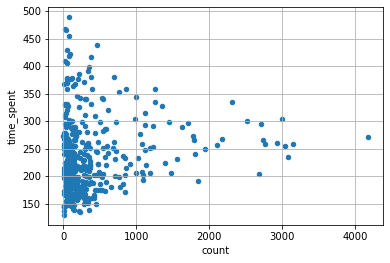

In [25]:
station_stat_full.plot(x='count',y ='time_spent',kind='scatter',grid=True)

АЗС с малым количеством заездов имеют значительный разброс медианного времени заправки (от120-500). Остальные обычно укладываются в границы 200-350 секунд. Отсюда возникает две идеи:
* АЗС с большим числом заездов - крупные, процессы на них отлажены
* Где мало заездов, там искажения более вероятны

По данным из таблицы station_stat_full посчитаем коэффициент корреляции Пирсона между числом заездов на АЗС и временем заправки

In [26]:
station_stat_full['count'].corr(station_stat_full['time_spent'])

0.12242632473597156

Корреляция близка к нулю, это может значить, что особой связи между числом заездов и временем нет, либо что есть влияние других факторов

            time_spent  too_fast  too_slow
time_spent    1.000000 -0.640658  0.802247
too_fast     -0.640658  1.000000 -0.255876
too_slow      0.802247 -0.255876  1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B0AB5D670>,
      dtype=object)

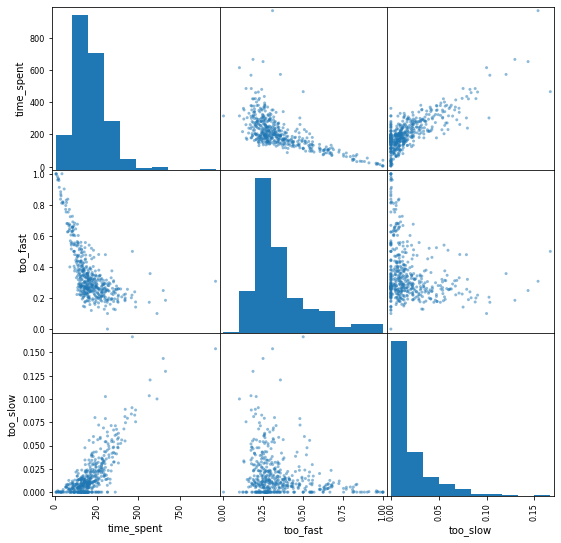

In [27]:
station_stat_multi = data.pivot_table(index ='id', values = ['time_spent', 'too_fast', 'too_slow'])
print(station_stat_multi.corr())
pd.plotting.scatter_matrix(station_stat_multi,figsize =(9,9))

Самый большой коэффициент корреляции: 0,8 между 'too_slow' и 'time_spent'. Это заметно и на соответствующей диаграмме рассеяния. Зная одно значение, можно предсказать другое. Если бы мы не отрезали слишком долгие заезды, они бы сказались на среднем времени. Поэтому так важно было их отбросить и вместо среднего значения взять медиану.
Зависимость между 'too_fast' и 'time_spent' интереснее. На диаграмме рассеяния видно, что при too_fast>0.6 (т.е. более 60% заездов на АЗС продолжались меньше минуты), среднее время почти полностью определяется как раз долей этих быстрых заездов. Если бы мы их не отфильтровали, типичное время заправки напоминало бы пит-стоп на «Формуле-1».

Продемонстрируем им два изображения: матрицу диаграмм рассеяния по исходным данным — и по отфильтрованным.

                 time_spent  too_fast  too_slow  good_time_spent
time_spent         1.000000 -0.640658  0.802247         0.702429
too_fast          -0.640658  1.000000 -0.255876        -0.315120
too_slow           0.802247 -0.255876  1.000000         0.445926
good_time_spent    0.702429 -0.315120  0.445926         1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B0B60FA60>,
      dtype=object)

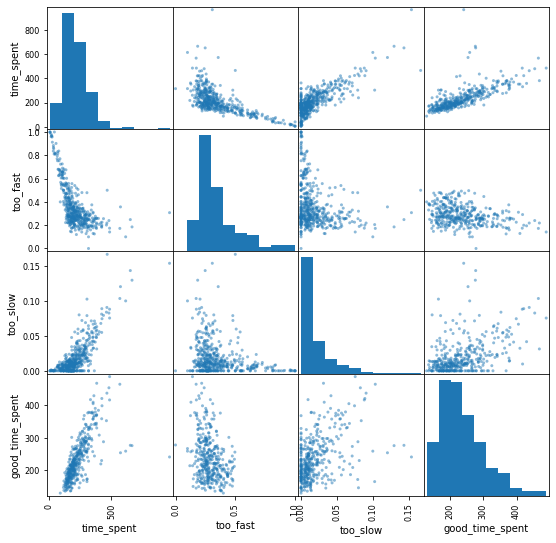

In [29]:
good_station_stat = good_data.pivot_table(
    index="id", values="time_spent", aggfunc="median"
)
station_stat_multi['good_time_spent'] = good_station_stat['time_spent']
print(station_stat_multi.corr())
pd.plotting.scatter_matrix(station_stat_multi ,figsize =(9,9))

Построим столбчатый график длительности заправки на каждой сети АЗС по наилучшей оценке — медиане, упорядочив сети по возрастанию времени. 

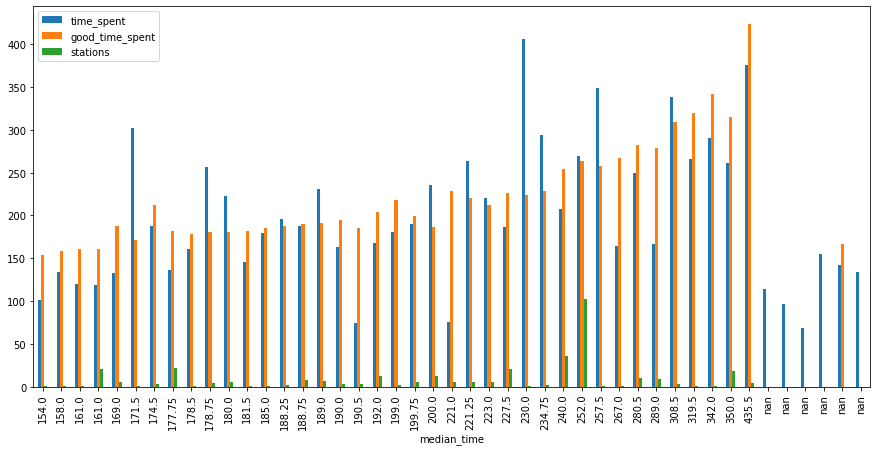

In [33]:
final_stat.sort_values(by = 'median_time').plot('median_time',kind='bar',figsize =(15,7))

Избавимся от сетей с пустыми значениями

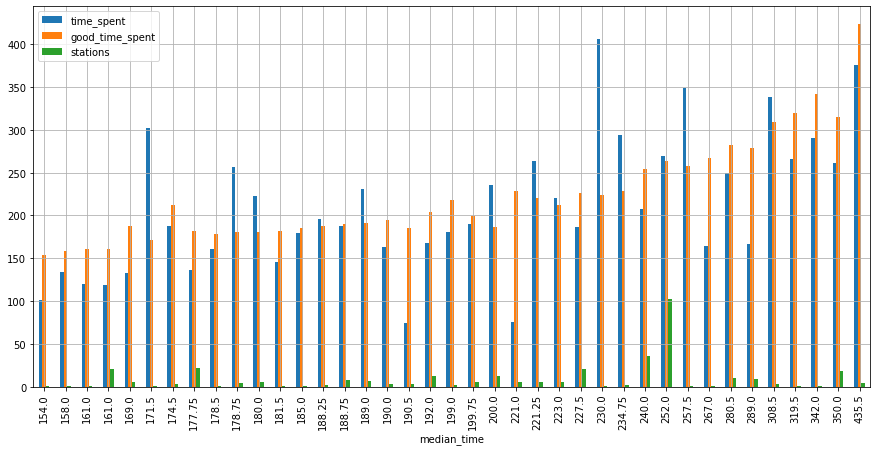

In [35]:
final_stat.dropna().sort_values(by = 'median_time').plot('median_time',kind='bar',figsize =(15,7),grid=True)

Хорошо видна условная граница, разделяющая быстрые и медленные сети.
Клинетам быстрых АЗС оплата заправки через Яндекс.Навигатор вряд ли принесет много ценности.Они и так заправляются, и платят быстро. А вот клиентам АЗС, чьи процесф отлажены не так хоршо, Яндекс.Навигатор поможет проводить меньше времения на станции.


Выявим самые крупные сети — построим гистограмму числа АЗС внутри сетей. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B0EA71BE0>]],
      dtype=object)

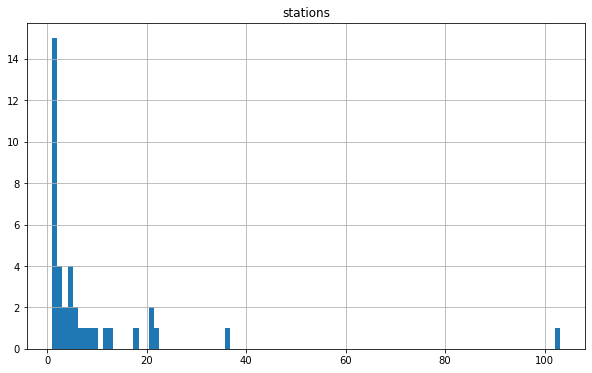

In [37]:
final_stat.hist('stations',bins=100,figsize=(10,6))

Выберем из final_stat сети, в которых более 10 АЗС. Результат сохраним в таблице big_nets_stat.

In [39]:
big_nets_stat = final_stat.query('stations > 10')
big_nets_stat

,time_spent,good_time_spent,median_time,stations
name,,,,
Василек,268.849897,264.0,252.00,103.0
Гейхера,167.445947,204.0,192.00,12.0
Календула,207.357323,254.0,240.00,36.0
Колокольчик,119.131564,161.0,161.00,21.0
Люпин,235.440937,186.0,200.00,13.0
Мальва,136.562234,182.0,177.75,22.0
Немезия,186.535207,226.0,227.50,21.0
Роза,260.877217,315.0,350.00,18.0


Создадим в station_stat_full новый столбец 'group_name', где для сетей АЗС из big_nets_stat названия останутся прежними, а имена остальных изменим на 'Другие'

In [40]:
station_stat_full['group_name'] = station_stat_full['name'].where(station_stat_full['name'].isin(big_nets_stat.index), 'Другие')
station_stat_full.head()

,name,count,time_spent,group_name
id,,,,
00ca1b70,Вероника,131,166.0,Другие
0178ce70,Василек,164,234.5,Василек
01abf4e9,Гацания,30,181.5,Другие
030a9067,Колокольчик,228,135.5,Колокольчик
03740f2d,Василек,157,289.0,Василек


Соберем таблицу с потенциальными ключевыми партнёрами.

In [41]:
stat_grouped = station_stat_full.query('count >30').pivot_table(index= 'group_name',values='time_spent',aggfunc = ['median','count'])
stat_grouped.columns = ['time_spent','count']
stat_grouped.sort_values(by='time_spent',ascending=True,inplace=True)
stat_grouped

,time_spent,count
group_name,,
Колокольчик,161.00,21
Мальва,177.75,22
Гейхера,192.00,12
Люпин,200.00,13
Другие,208.75,104
Немезия,227.50,21
Календула,240.00,36
Василек,252.00,103
Роза,350.00,18


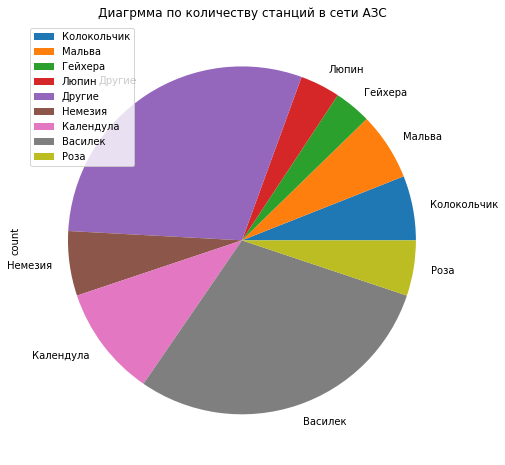

In [44]:
stat_grouped.plot(y='count',kind='pie',figsize=(8,8),title="Диагрмма по количеству станций в сети АЗС")

### Мы получили финальный список наиболее интересных АЗС:
* "Роза". Самая медленная среди крупных сетей.
* "Василек".Вторая по медлительности, но очень крупная по размерам.
* "Календула". Близка по времени к "Васильку" и вторая по размерам.
* "Немезия".Последняя из медленных и сравнительно крупных АЗС.

Создадим в good_data новый столбец 'group_name', где сетям из big_nets_stat оставим их оригинальные имена, а остальные сети переименуем на 'Другие'.

In [45]:
good_data['group_name'] = good_data['name'].where(good_data['name'].isin(big_nets_stat.index), 'Другие')
good_data.head()

,date_time,id,time_spent,name,local_time,date_hour,too_fast,too_slow,group_name
0,2018-04-06 16:53:58,76144fb2,98.0,Василек,2018-04-06 19:53:58,2018-04-06 20:00:00,False,False,Василек
2,2018-04-03 17:28:24,76144fb2,220.0,Василек,2018-04-03 20:28:24,2018-04-03 20:00:00,False,False,Василек
6,2018-04-02 08:23:21,76144fb2,555.0,Василек,2018-04-02 11:23:21,2018-04-02 11:00:00,False,False,Василек
7,2018-04-07 00:34:08,76144fb2,286.0,Василек,2018-04-07 03:34:08,2018-04-07 04:00:00,False,False,Василек
9,2018-04-05 13:19:39,76144fb2,248.0,Василек,2018-04-05 16:19:39,2018-04-05 16:00:00,False,False,Василек


Методом hist() построим гистограмму продолжительности заправки для каждой сети отдельно.

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


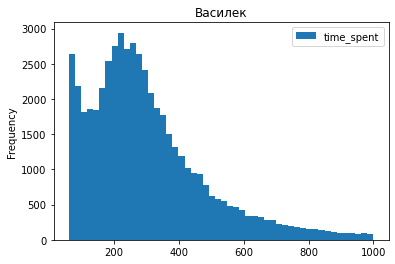

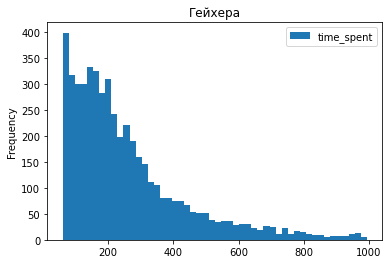

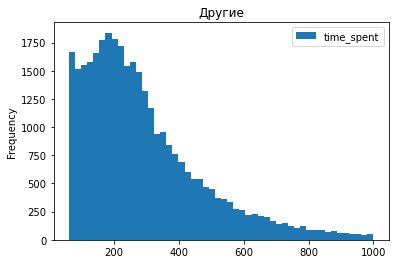

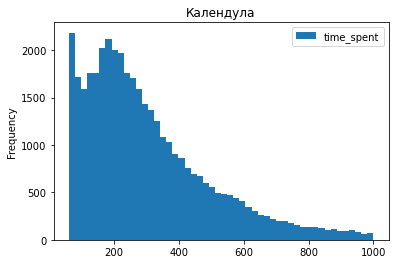

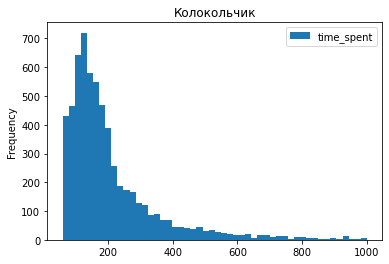

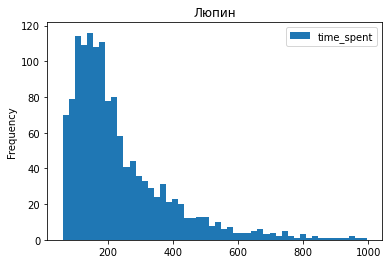

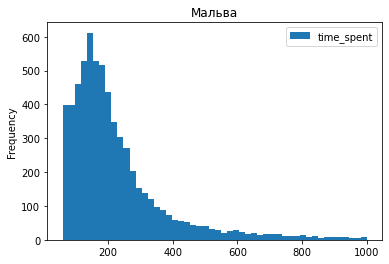

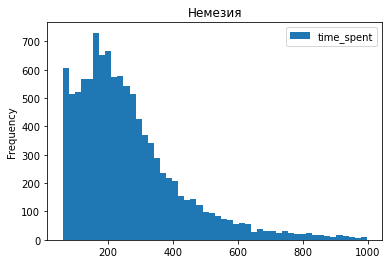

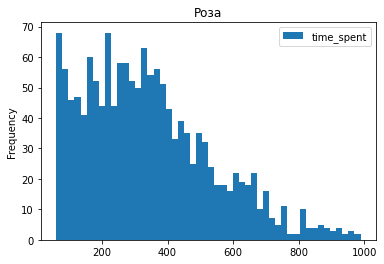

In [47]:
for name,group_data in good_data.groupby('group_name'):
    print(group_data.plot(y='time_spent',kind='hist',title=name,bins=50))